In [1]:
# importing all necessary modules
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import numpy as np
import re
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import BisectingKMeans
from sklearn.preprocessing import StandardScaler, normalize
import pickle

In [2]:
np.random.seed()

In [3]:
# if(not exists('data/templates.txt')):
# 	f = open('data/templates.json')
# 	f1 = open('data/templates.txt', 'w')
# 	data = json.load(f)
# 	for i in data.items():
# 		f1.write(i[1])
# 		f1.write("\n")
# 	f.close()
# 	f1.close()

sample = open("data/preprocessed_logs_word_APP1.txt")
f = sample.readlines()

# Replaces escape character with space
# f = s.replace("\n", " ")

In [4]:
data = []

# iterate through each sentence in the file
for i in f:
	temp = []
	# tokenize the sentence into words
	for j in word_tokenize(i):
		if(not re.search('[+-]?([0-9]*[.])?[0-9]+', j.lower())):
			temp.append(j.lower())
	data.append(temp)

In [64]:
len(data)

306185

### CBOW MODEL

In [5]:
# Create CBOW model
print('CBOW: ')
model1 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)
model1.build_vocab(data, progress_per=1000)
model1.train(data, total_examples=model1.corpus_count, epochs=model1.epochs)

CBOW: 


(1451917, 7506305)

In [6]:
# saving model
model1.save("data/CBOW_APP1.model")

In [7]:
new_data = []

for i, sent in enumerate(data):
    vector = [0]*100
    for j, word in enumerate(sent):
        vector += model1.wv[word]
    new_data.append(vector)

In [8]:
# clustering
vectors = new_data

In [9]:
scaler = StandardScaler()

In [10]:
X_scaled = scaler.fit_transform(new_data)

In [11]:
X_normalized = normalize(X_scaled)

In [12]:
X_normalized = pd.DataFrame(X_normalized)

In [73]:
X_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.030047,-0.047032,-0.095404,0.065974,-0.136060,0.153856,-0.059903,0.024664,-0.067964,0.099015,...,-0.175059,-0.112363,0.013553,0.030626,-0.033051,-0.042292,0.001126,0.168819,0.202652,0.045557
1,-0.106367,0.134124,-0.060745,0.086385,-0.084285,-0.164183,0.162280,0.025759,-0.144411,-0.164249,...,0.121958,0.078112,-0.030613,0.153316,0.086838,-0.013966,-0.155213,-0.115724,-0.008571,-0.148414
2,-0.106367,0.134124,-0.060745,0.086385,-0.084285,-0.164183,0.162280,0.025759,-0.144411,-0.164249,...,0.121958,0.078112,-0.030613,0.153316,0.086838,-0.013966,-0.155213,-0.115724,-0.008571,-0.148414
3,-0.028102,-0.116702,-0.074101,0.081748,0.060449,0.133595,0.022084,0.006615,-0.036132,0.150820,...,-0.154368,-0.099173,0.030532,0.040706,-0.039872,-0.019019,-0.000546,0.123349,0.063181,-0.093074
4,-0.106367,0.134124,-0.060745,0.086385,-0.084285,-0.164183,0.162280,0.025759,-0.144411,-0.164249,...,0.121958,0.078112,-0.030613,0.153316,0.086838,-0.013966,-0.155213,-0.115724,-0.008571,-0.148414


In [13]:
pca = PCA(n_components = 2)

In [14]:
X_principal = pca.fit_transform(X_normalized)

In [15]:
X_principal = pd.DataFrame(X_principal)

In [16]:
X_principal.columns = ['P1', 'P2']

In [ ]:
plt.figure(figsize =(8, 8), facecolor='w')
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

In [17]:
# saving scalar & PCA
with open('data/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('data/pca.pickle', 'wb') as f:
    pickle.dump(pca, f)

In [ ]:
# agglomerative clustering
k = []
ac = []
silhouette_scores = []

for i in range(2, 5):
        k.append(i)
        ac.append(BisectingKMeans(n_clusters = i))
        silhouette_scores.append(
                silhouette_score(X_principal, ac[i-2].fit_predict(X_principal)))
  
# Plotting a bar graph to compare the results
plt.figure(facecolor='w')
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

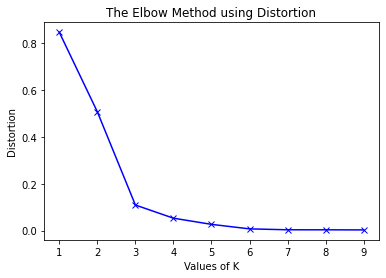

In [18]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = BisectingKMeans(n_clusters=k)
    kmeanModel.fit(X_principal)
  
    distortions.append(sum(np.min(cdist(X_principal, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_principal.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X_principal, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_principal.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.figure(facecolor='w')
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

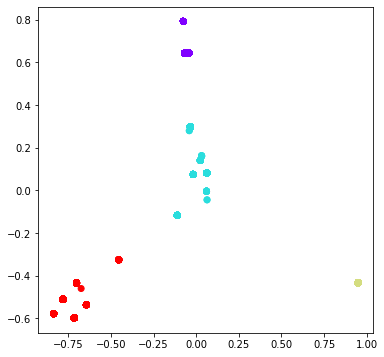

In [25]:
# x = silhouette_scores.index(max(silhouette_scores)) + 2

ac = BisectingKMeans(n_clusters = 4)

plt.figure(figsize =(6, 6), facecolor='w')
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()

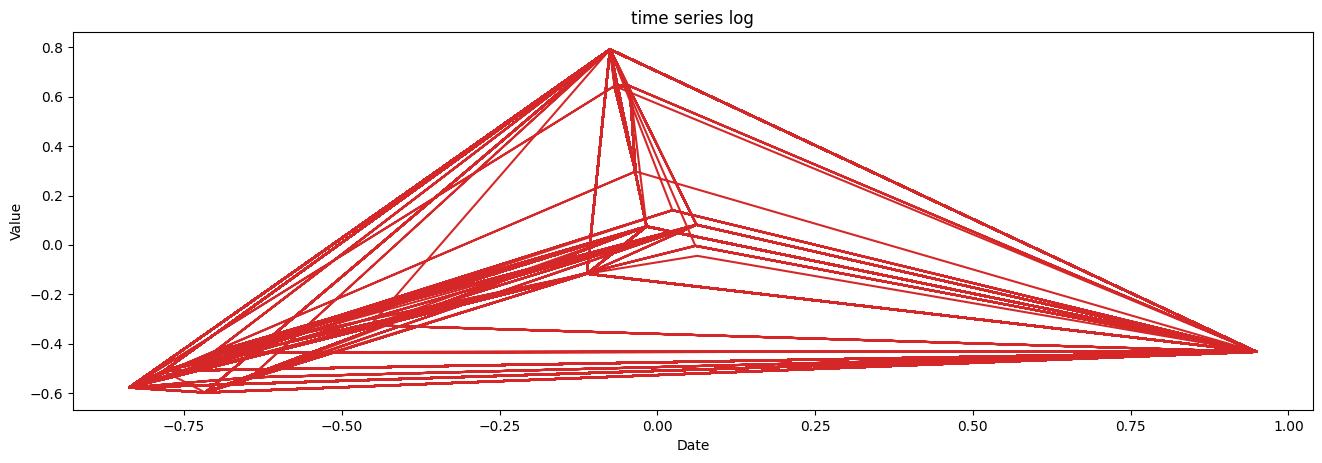

In [22]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi, facecolor='w')
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(x= X_principal['P1'][:50000], y= X_principal['P2'][:50000], title='time series log')

In [23]:
# saving clustering
with open('data/ac.pickle', 'wb') as f:
    pickle.dump(ac, f)

In [24]:
with open('data/x_of_app1.pickle', 'wb') as f:
    pickle.dump(X_principal, f)

### SKIP GRAM

In [ ]:
# Create Skip Gram model
print('\nSKIP GRAM: ')
model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg=1)
model2.build_vocab(data, progress_per=1000)
model2.train(data, total_examples=model1.corpus_count, epochs=model1.epochs)


SKIP GRAM: 


(50000, 7935430)

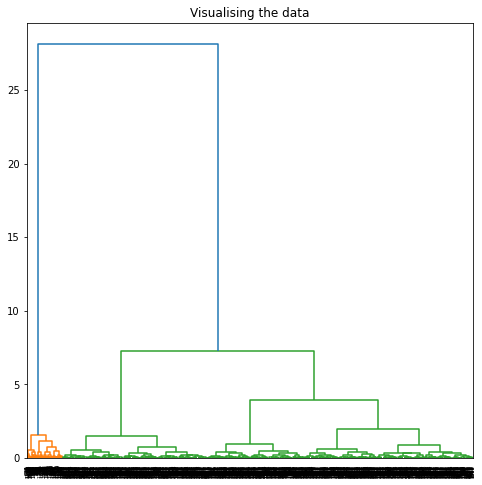

In [ ]:
# clustering
vectors = model2.wv.vectors

scaler = StandardScaler()
X_scaled = scaler.fit_transform(vectors)
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize =(8, 8), facecolor='w')
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

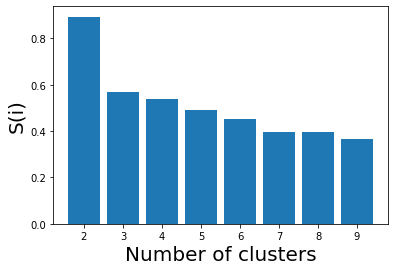

In [ ]:
# agglomerative clustering
k = []
ac = []
silhouette_scores = []

for i in range(2, 10):
        k.append(i)
        ac.append(AgglomerativeClustering(n_clusters = i))
        silhouette_scores.append(
                silhouette_score(X_principal, ac[i-2].fit_predict(X_principal)))
  
# Plotting a bar graph to compare the results
plt.figure(facecolor='w')
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

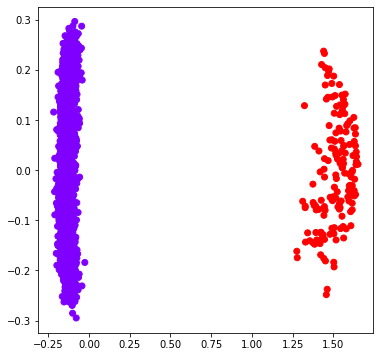

In [ ]:
x = silhouette_scores.index(max(silhouette_scores)) + 2
ac = AgglomerativeClustering(n_clusters = x)

plt.figure(figsize =(6, 6), facecolor='w')
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()